# ***Integration with Gridap***

Numerical integration is a cornerstone of scientific computing, enabling us to approximate integrals of functions that may not have closed-form solutions. In the realm of finite element analysis (FEA), numerical integration plays a critical role in solving partial differential equations (PDEs) by discretizing complex geometries and approximating integral expressions over finite elements.

In this tutorial, we'll guide you through the fundamentals of numerical integration using Gridap. By the end of this tutorial, you will learn how to:

- Define a computational domain and function spaces in Gridap.
- Numerically integrate functions over domains and subdomains.
- Use quadrature rules effectively within the finite element framework.

This tutorial assumes a basic understanding of Julia programming and familiarity with the concept of numerical integration. If you're new to Gridap, don't worry—we'll provide clear examples and explanations to help you get started. Let's dive into the world of numerical integration with Gridap!

In [338]:
using Gridap
using Plots
using GridapMakie
using CairoMakie 
using GLMakie
using Gridap.Geometry
using GridapGmsh
using Gmsh: Gmsh, gmsh

## **Defining the Computational Domain and the Function**
To perform numerical integration, we first need to define the region (or domain) over which the function will be integrated. Here's what happens in this cell:

- **Interval Width:** The domain is defined as $[0, \pi]$, the interval where we will compute the integral.
- **Partitioning the Domain:** The interval is divided into `n_partition` subintervals to discretize the domain. This partitioning is essential for numerical methods because we approximate the integral by summing contributions from smaller, manageable subregions.
- **Discrete Model:** A CartesianDiscreteModel is created to represent the discretized domain in Gridap. This is a fundamental step in finite element analysis because it sets up the computational mesh on which all operations will take place.
- **Defining the Function $(f(x))$:** We consider the function $f(x) = \sin(x)$, whose integral over the domain is known analytically $(=2)$. This allows us to compare the accuracy of the numerical integration with the exact solution.

This setup lays the groundwork for the numerical integration process, ensuring the problem is well-defined in the context of finite element methods.


In [393]:
interval_width = pi
domain = (0, interval_width)
n_partition = 10
partition = (n_partition,)
model = CartesianDiscreteModel(domain, partition)

# The function we consider for integration
f(x) = sin(x)

f (generic function with 1 method)

## **Building the Finite Element Space**
Finite element methods (FEM) rely on creating function spaces that approximate the behavior of the functions we want to work with. For further details on function spaces, we refer back to the first tutorial about Gridap. In this cell, we take the following steps:

- **Finite Element Space (FE Space):** We define an FE space using a Lagrangian reference element with a polynomial order of 2. This determines how smooth and accurate the approximation will be within each subinterval.
- **Evaluating Function Values:** The function $f(x) = \sin(x)$ is evaluated at discrete points defined by the FE space's resolution. These values represent the approximation of $f(x)$ on the finite element space.
- **High-Resolution Analytical Values:** For comparison, we also compute the values of $\sin(x)$ at a much higher resolution (100 points over the domain). These values serve as a reference to validate the finite element approximation.

By constructing this FE space, we are essentially creating a framework that allows us to represent and operate on $f(x)$ in a way that's computationally efficient while maintaining reasonable accuracy.


In [400]:
# Build an FE space
order = 2
reffe = ReferenceFE(lagrangian, Float64, order)
V = FESpace(model, reffe)

interval = range(0, interval_width, order*n_partition+1)
sin_values = f.(interval);

interval_analytical = range(0, interval_width, 1000)
sin_values_analytical = f.(interval_analytical);

## **Creating the Finite Element Function**
The goal of this step is to create a discrete representation of the function $f(x)$ using the FE space:

- **FE Function:** An FEFunction is initialized using the FE space and the previously computed discrete values of $f(x)$. This function now represents $f(x)$ in a way that is compatible with the FEM framework. We basically interpolate between the computed discrete values of $f(x)$ using the basis functions of the defined FE space.
- **Extracting Values:** The free degrees of freedom (DoF) values of the FE function are extracted to ensure the representation aligns with the computational model and for visualization reasons.

This step is critical because the FE function bridges the gap between the continuous mathematical definition of \(f(x)\) and its numerical approximation over the discrete domain.


In [401]:
sin_FEFunction = FEFunction(V, sin_values)
sin_FEFunction_values = get_free_dof_values(sin_FEFunction)  # Get the values of the FEFunction

21-element Vector{Float64}:
 0.0
 0.15643446504023087
 0.3090169943749474
 0.45399049973954675
 0.5877852522924731
 0.7071067811865475
 0.8090169943749475
 0.8910065241883678
 0.9510565162951535
 0.9876883405951378
 ⋮
 0.9510565162951536
 0.8910065241883679
 0.8090169943749475
 0.7071067811865476
 0.5877852522924732
 0.45399049973954686
 0.3090169943749475
 0.15643446504023098
 1.2246467991473532e-16

## **Visualizing the Finite Element Function and the Analytical Function**
Visualization is a powerful tool to understand and validate numerical methods. In this step:

- **Plotting the FE Function:** We plot the values of the FE function over the interval $[0, \pi]$. This provides a visual representation of the finite element approximation of $f(x)$.
- **Plotting the Analytical Function:** The analytical function $\sin(x)$ is also plotted for comparison. This helps us see how closely the FE function approximates the true function.

By comparing the two plots, students can observe the effectiveness of the finite element approximation. Any discrepancies can be linked back to the choices made in discretization (e.g., the order of the FE space or the partition size).


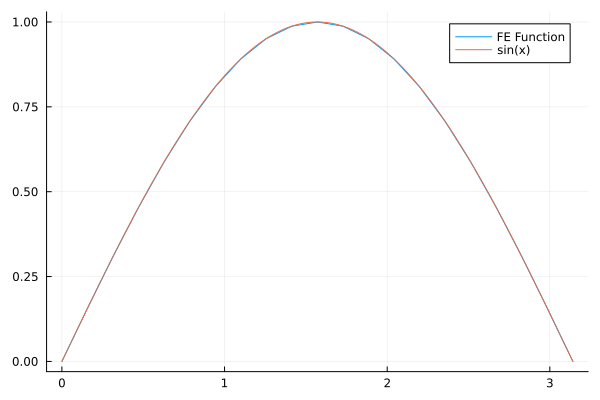

In [402]:
Plots.plot(interval, sin_values, label="FE Function")
Plots.plot!(interval_analytical, sin_values_analytical, label="sin(x)")

## **Analyzing Integration Errors**
Numerical integration relies on quadrature rules, which approximate the value of an integral by summing weighted contributions from sample points. In this cell, we evaluate how the degree of the quadrature rule impacts the accuracy of the numerical integral:

- **Triangulation:** The computational domain is triangulated to facilitate numerical integration. This divides the domain into smaller, manageable regions.
- **Degree of Quadrature Rule:** A loop iterates over quadrature rules with degrees ranging from 1 to 10. Higher-degree quadrature rules use more sample points and weights, leading to more accurate results.
- **Numerical vs. Analytical Integration:** For each degree, the numerical integral of the FE function is computed and compared with the known analytical integral $(= 2)$. The error is calculated as the root of the squared difference between the numerical and analytical values.
- **Plotting the Error:** The integration error is plotted as a function of the quadrature degree. This plot visually demonstrates how increasing the degree of the quadrature rule improves accuracy, showcasing the trade-off between computational effort and precision.

This analysis highlights the importance of choosing appropriate quadrature rules in finite element analysis and how they affect the accuracy of numerical results.

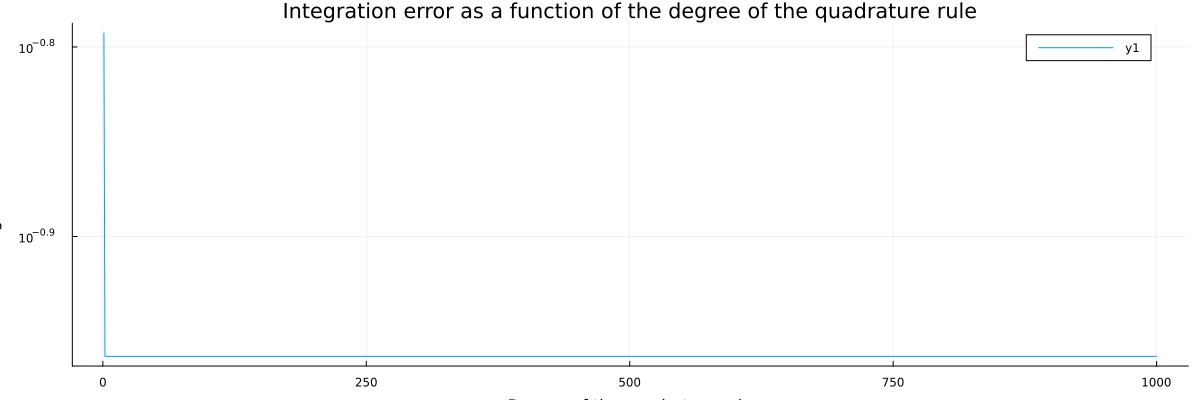

In [410]:
trian = Triangulation(model)

# Write a loop that plots the integration error as a function of the degree of the quadrature rule
error_array = []
for degree in 2*order:1000
    dΩ = Measure(trian, degree)
    integrate_sin_numerical = sum(∫(sin_FEFunction)dΩ)
    integrate_sin_analytical = 2 # Analytical value of the integral of sin(x) in the interval [0, pi]
    error = sqrt((integrate_sin_numerical - integrate_sin_analytical)^2)
    push!(error_array, error)
end

Plots.plot(error_array, xlabel="Degree of the quadrature rule", ylabel="Integration error", yscale=:log10, title="Integration error as a function of the degree of the quadrature rule", size = (1200,400))